### **Importing Libraries**

In [16]:
import numpy as np # For numeric operations
import pandas as pd # For using dataframes
import seaborn as sns # For vizualizations
import matplotlib.pyplot as plt # For vizualizations
from sklearn.model_selection import train_test_split # To split the dataset
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

### Deep Learning Modules ### Using tensorflow 2.4.1
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import save_model, load_model

### Modules for cleaning text
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')

### For removing warnings
import warnings
warnings.filterwarnings('ignore')

### Web App
from flask import Flask, render_template, request 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Zain\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **Loading the dataset**

In [2]:
df_train = pd.read_csv('train.csv') # Training data 
df_test = pd.read_csv('test.csv') # Testing data
df_train.head() # Printing the head of training data (first 5 rows)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


### **Exploratory Data Analysis**

<AxesSubplot:xlabel='label', ylabel='count'>

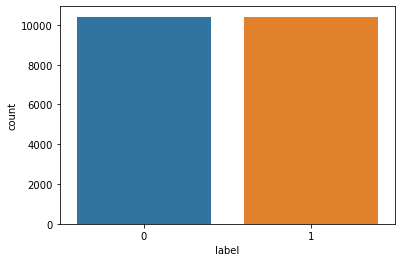

In [3]:
### Distribution of target class
sns.countplot(df_train['label'])

> We can see we have 10000 samples for each class and dataset is perfectly balanced

### **Pre-Processing**

> #### Dealing with Null Values

In [4]:
### Filling all null values in training and testing data with the empty string 
df_train = df_train.fillna('')
df_test = df_test.fillna('')

> #### Making a New Column With Interested data

In [5]:
# We will be only using title and author name for prediction
# Making a  new column data concatenating title and author
df_train['data'] = df_train['title']+' '+df_train['author']
df_test['data'] = df_test['title']+' '+df_test['author']

In [6]:
df_train.head()

,id,title,author,text,label,data
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


> We have the final column with title and author info in it. We will use this info alone to predict if the news is fake or not

> #### Separating Features And Target Variable

In [7]:
X = df_train.drop('label', axis=1) # Separating features
y = df_train['label'] # separating target variables
print(X.shape)
print(y.shape)

(20800, 5)
(20800,)


> #### Vocabulary

In [8]:
# Choosing the vocabulary size to 5000 and making a copy of data for futher manipulations
vocabulary_size = 5000
df_train_copy = X.copy()
df_test_copy = df_test.copy()

> #### Stemming

In [9]:
### With the help of stemming, different forms of words get matches to their base form (quicker --> quick, faster --> fast etc.)
ps = PorterStemmer() # initializing the stemmer
train_corpus = []

### Applying stemming and some preprocessing
for i in range(len(df_train_copy)):
  text = re.sub('[^a-zA-Z]',' ',df_train_copy['data'][i])
  text = text.lower()
  text = text.split()
  text = [ps.stem(word) for word in text if not word in stopwords.words('english')]
  text = ' '.join(text)
  train_corpus.append(text)

### Applying stemming and some preprocessing for test data
test_corpus = []
for i in range(len(df_test_copy)):
  text = re.sub('[^a-zA-Z]',' ',df_test_copy['data'][i])
  text = text.lower()
  text = text.split()
  text = [ps.stem(word) for word in text if not word in stopwords.words('english')]
  text = ' '.join(text)
  test_corpus.append(text)

> #### One-Hot-Encoding

In [10]:
# With one hot encoding if a a sentence contain a word in vocabulary it convert the word into number 1 else 0 (because machine only understands numbers not text)
train_one_hot = [one_hot(words, vocabulary_size)for words in train_corpus]
test_one_hot = [one_hot(words, vocabulary_size)for words in test_corpus]

> #### Padding

In [11]:
# Padding the sentences so that all sentences are of same length because Deep learning model can take only data in single shape
train_embedded_docs = pad_sequences(train_one_hot, padding='pre', maxlen=25)
test_embedded_docs = pad_sequences(test_one_hot, padding='pre', maxlen=25)

### **Deep Learning Model**

> #### Model Architecture

In [12]:
model = Sequential() # Initializing the sequential model

### Adding layers to the models, I have used Embedding and LSTM layers
### Dropout layers are used to avoid overfitting of the model
model.add(Embedding(vocabulary_size, 40, input_length=25)) # Embedding layer with 40 units
model.add(Dropout(0.3)) # Dropout layer to turn of 30% neurons from previous layer to avoid overfitting
model.add(LSTM(100)) # LSTM layer with 100 neurons
model.add(Dropout(0.3)) # Dropout layer to turn of 30% neurons from previous layer to avoid overfitting
model.add(Dense(64, activation='relu')) # Dense layer with 64 neurons
model.add(Dropout(0.3)) # Dropout layer to turn of 30% neurons from previous layer to avoid overfitting
model.add(Dense(1, activation='sigmoid')) # Last dense layer with 1 neuron and signoid as activation because its binary class classification 

### Compiling the model, with binary loss as its a binary class classification problem
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary() # Printing the summary of model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 40)            200000    
                                                                 
 dropout (Dropout)           (None, 25, 40)            0         
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

> #### Preparing the data for Model

In [13]:
# Converting the data into numpy array
X_final = np.array(train_embedded_docs)
y_final = np.array(y)

X_train, X_val, y_train, y_val = train_test_split(X_final, y_final, test_size=0.2, random_state=0) # Reserving 20% of data for validation dataset

test_final = np.array(test_embedded_docs)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, test_final.shape

((16640, 25), (16640,), (4160, 25), (4160,), (5200, 25))

> #### Training the Model

In [14]:
# Training the model for 20 epochs with a batch size of 64
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64)

Epoch 1/20
260/260 [==============================] - 6s 16ms/step - loss: 0.1735 - accuracy: 0.9254 - val_loss: 0.0418 - val_accuracy: 0.9853
Epoch 2/20
260/260 [==============================] - 4s 14ms/step - loss: 0.0208 - accuracy: 0.9944 - val_loss: 0.0328 - val_accuracy: 0.9911
Epoch 3/20
260/260 [==============================] - 4s 14ms/step - loss: 0.0100 - accuracy: 0.9975 - val_loss: 0.0338 - val_accuracy: 0.9899
Epoch 4/20
260/260 [==============================] - 4s 15ms/step - loss: 0.0042 - accuracy: 0.9989 - val_loss: 0.0442 - val_accuracy: 0.9897
Epoch 5/20
260/260 [==============================] - 4s 14ms/step - loss: 0.0037 - accuracy: 0.9988 - val_loss: 0.0388 - val_accuracy: 0.9909
Epoch 6/20
260/260 [==============================] - 4s 14ms/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.0499 - val_accuracy: 0.9887
Epoch 7/20
260/260 [==============================] - 4s 14ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0511 - val_accuracy: 0.9897

> #### Loss & Accuracy Plot

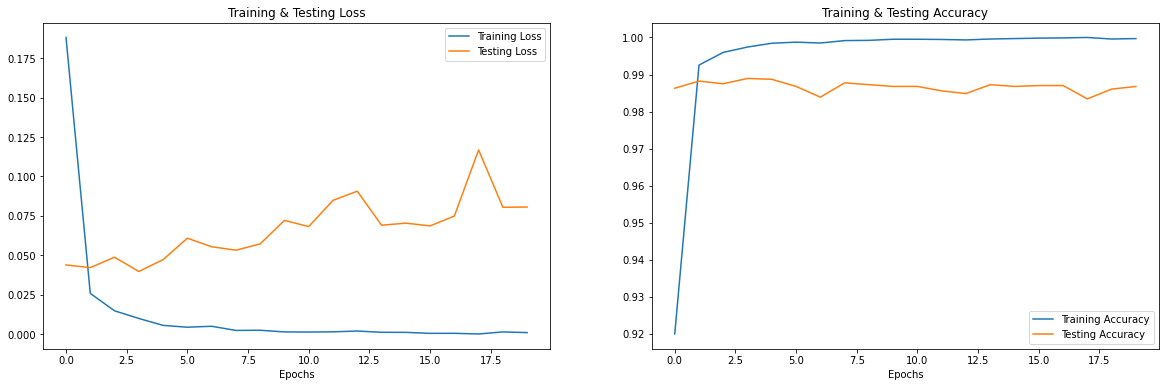

In [15]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

> We can see that as training and validation loss on decreasing as training goes by, while the training and validation accuracy kept on increasing. Hence there is no overfitting in the model.

>#### Evaluation on Validation Set

Confussion Matrix:


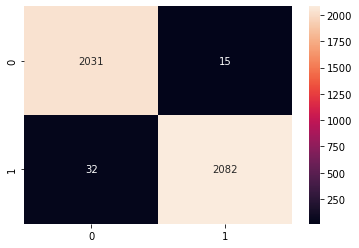


Accuracy of Model on Validation Set: 
 98.8701923076923 

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2046
           1       0.99      0.98      0.99      2114

    accuracy                           0.99      4160
   macro avg       0.99      0.99      0.99      4160
weighted avg       0.99      0.99      0.99      4160



In [19]:
y_pred_val = (model.predict(X_val) > 0.5).astype("int32") # Getting prediction on Validation Set

conf_matrix_val = confusion_matrix(y_val, y_pred_val) # Calculating Confusion Matrix
acc_score_val = accuracy_score(y_val, y_pred_val) # Calculating Accuracy Score on Val Data

print("Confussion Matrix:")
sns.heatmap(conf_matrix_val, annot=True, fmt="d")  # Plotting Confusion Matrix as Heatmap
plt.show()

print("\nAccuracy of Model on Validation Set: \n", acc_score_val*100,'\n') # Printing Accuracy
print("Classification Report:")
print(classification_report(y_val, y_pred_val)) # Printing Classifcation Report

> We can see that the overall accuracy of our model on validation data is 99%. The individual precision of each class can also be seen. For class 1 (Fake) the model's accuracy is 99% while for class 0 (not-fake), the accuracy is 98%. We can also see the individual recall and f1 score as well which are really good in our case. This report is based on the support of 4160 samples from validation data

> #### Prediction on Test Set

In [28]:
y_pred = (model.predict(test_final) > 0.5).astype("int32") # Getting Prediction on Test Data

In [29]:
### Saving the Predictions on Test Set as a CSV file

prediction_test_df = pd.DataFrame()
prediction_test_df['id'] = df_test['id']
prediction_test_df['label'] = y_pred
prediction_test_df.to_csv('prediction_test_df.csv', index=False)
prediction_test_df.head()

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1


> #### Exporting Model

***

In [30]:
save_model(model, 'model.h5') # Saving the model 

### **Web App Using Flask**

In [31]:
model_ = load_model('model.h5') # Importing the pre-trained model

app = Flask(__name__)

@app.route('/') # Home page for the applicatoin
def main():
    return render_template('home.html')

@app.route('/predict', methods=['POST', 'GET'])
def home(): # Getting information from html page
    
    ### On POST request, extracting data from FORM fields
    author = request.form['author']
    sample_text = request.form['title']
    
    ### Pre-Processing the input data
    ps = PorterStemmer()
    input_text = sample_text + ' ' + author
    test_corpus = []
    text = re.sub('[^a-zA-Z]',' ', input_text)
    text = text.lower()
    text = text.split()
    text = [ps.stem(word) for word in text if not word in stopwords.words('english')]
    text = ' '.join(text)
    test_corpus.append(text)
    ### Preparing Input
    test_one_hot_ = [one_hot(words, 5000)for words in test_corpus]
    test_embedded_docs_ = pad_sequences(test_one_hot_, padding='pre', maxlen=25)
    test_final_ = np.array(test_embedded_docs_)
    ### Getting Predictions
    prediction_sent = (model_.predict(test_final_) > 0.5).astype("int32")
    return render_template('after.html', data=prediction_sent[0][0]) # Passing the data to response html page

app.run(host='0.0.0.0', port=8080) ### Starting Flask App

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses.
 * Running on http://192.168.100.29:8080/ (Press CTRL+C to quit)
192.168.100.29 - - [04/Jan/2022 02:16:38] "GET / HTTP/1.1" 200 -
192.168.100.29 - - [04/Jan/2022 02:20:04] "POST /predict HTTP/1.1" 200 -
192.168.100.29 - - [04/Jan/2022 02:20:21] "GET / HTTP/1.1" 200 -
192.168.100.29 - - [04/Jan/2022 02:20:53] "POST /predict HTTP/1.1" 200 -
